In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
train_df=pd.read_csv('train.csv')

In [4]:
train_df.shape

(9557, 143)

<h2>Check the datatypes of the dataset<h2>

In [5]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,130
1,float64,8
2,object,5


<h2>Target Value Distribution in Training dataset</h2>

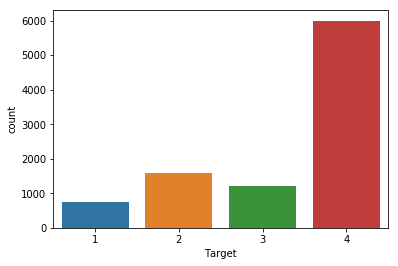

In [6]:
sns.countplot(x="Target",  data=train_df)

<h2> Non Numeric value cleansing<h2>

In [7]:
train_df_2=train_df.drop(['Id','v2a1'],axis=1)
list_to_compare=['no','yes','No','Yes','NO','YES']
for col in train_df_2:
    unique=train_df_2[col].unique()
    if (set(list_to_compare)&set(unique)):
        print("Column ",col,"has the values ",set(list_to_compare)&set(unique))

Column  dependency has the values  {'no', 'yes'}
Column  edjefe has the values  {'no', 'yes'}
Column  edjefa has the values  {'no', 'yes'}


Let us replace all yes with 1 and no with 0 as defined in the competition page, data description.

In [8]:
train_df=train_df.replace('no','0')
train_df=train_df.replace('yes','1')

We can now verify that there are no non numeric values in the dataset.

<h2> Check number of missing values in the dataset<h2>

In [9]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
103,meaneduc,5
140,SQBmeaned,5
1,v2a1,6860
8,v18q1,7342
21,rez_esc,7928


<h2>Imputation Process <h2>

Let us first consider the column meaneduc. For now, i will just remove the 4 rows which are having null values in this column and will revisit later and check if it increases the accuracy of the model. Removing meaneduc rows with null meaneduc will also take care of null values in SQBmeaned.

In [10]:
train_df.groupby(['idhogar','v18q']).aggregate('count')['v18q1'].reset_index()

,idhogar,v18q,v18q1
0,001ff74ca,1,2
1,003123ec2,0,0
2,004616164,0,0
3,004983866,0,0
4,005905417,0,0
5,006031de3,1,4
6,006555fe2,0,0
7,00693f597,0,0
8,006b64543,0,0
9,00941f1f4,0,0


All the blank values in v18q1 can be imputed with 0 safely since the null values exist where individual tablet count is 0. When the individual count is 0, the overall household count will also be 0

Imputing rez_esc also with 0 for now as I am unable to find any correlation or any other suitable stratergy to impute this column with.

In [11]:
train_df['rez_esc'].fillna(0, inplace=True)

Now the last column that needs imputation is v2a1. This is a continuous numerical column which provides the rent paid for each of the house. I think the best way to impute this is by applying a regressor here. v2a1 will be our target variable and rest of the datasets will be our independent features. Next bit of code will prepare the dataset so that we can apply a regressor. Let us apply a RF Regressor

In [12]:
train_df=train_df[~train_df['meaneduc'].isnull()]

In [13]:
train_df['v18q1'].fillna(0, inplace=True)

In [14]:
train_df['rez_esc'].fillna(0, inplace=True)

In [15]:
train_df_reg=train_df

In [16]:
train_df_reg=train_df

In [17]:
train_df_reg_train=train_df_reg[~train_df_reg['v2a1'].isnull()]

In [18]:
train_df_reg_train.shape

(2693, 143)

In [19]:
train_df_reg_test=train_df_reg[train_df_reg['v2a1'].isnull()]

In [20]:
train_df_reg_test.shape

(6859, 143)

In [21]:
train_df_reg_train_Y=train_df_reg_train['v2a1']

In [22]:
train_df_reg_test_Y=train_df_reg_test['v2a1']

In [23]:
train_df_reg_train_X=train_df_reg_train.loc[:, train_df_reg_train.columns != 'v2a1']

In [24]:
train_df_reg_test_X=train_df_reg_test.loc[:, train_df_reg_test.columns != 'v2a1']

In [25]:
train_df_reg_train_X_id=train_df_reg_train_X


In [26]:
train_df_reg_train_X=train_df_reg_train_X.drop(['Id','idhogar'],axis=1)

In [27]:
train_df_reg_test_X_id=train_df_reg_test_X

In [28]:
train_df_reg_test_X=train_df_reg_test_X.drop(['Id','idhogar'],axis=1)

In [29]:
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)

In [30]:
regr.fit(train_df_reg_train_X,train_df_reg_train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
train_df_reg_test_Y=regr.predict(train_df_reg_test_X)

In [32]:
train_df_reg_test_Y=np.round(train_df_reg_test_Y)

In [33]:
train_df_reg_test_Y = pd.DataFrame(train_df_reg_test_Y, dtype='float')

In [34]:
train_df_reg_test_Y.shape

(6859, 1)

In [35]:
train_df_reg_test_Y

,0
0,256480.0
1,56906.0
2,103641.0
3,242577.0
4,162029.0
5,162029.0
6,163129.0
7,162029.0
8,162029.0
9,432038.0


In [36]:
train_df_reg_test_X_id.loc[:,'v2a1']=train_df_reg_test_Y.values

In [37]:
train_df_reg_test_X_id.shape

(6859, 143)

In [38]:
train_df_reg_train_X_id.loc[:,'v2a1']=train_df_reg_train_Y.values

In [39]:
train_df_reg_train_X_id['v2a1']

0       190000.0
1       135000.0
3       180000.0
4       180000.0
5       180000.0
6       180000.0
7       130000.0
8       130000.0
9       130000.0
10      130000.0
11      100000.0
12      100000.0
15       90000.0
16       90000.0
17       90000.0
18       90000.0
19      215000.0
20      215000.0
21      150000.0
22      150000.0
23      100000.0
24      100000.0
25      100000.0
27      120000.0
28      120000.0
29      120000.0
30      100000.0
31      100000.0
37       80000.0
38       80000.0
          ...   
9475         0.0
9476         0.0
9477         0.0
9478         0.0
9479         0.0
9481     40000.0
9482     40000.0
9483     35000.0
9484     35000.0
9485     35000.0
9486     35000.0
9502     30000.0
9503     30000.0
9519    300000.0
9520    300000.0
9521    300000.0
9528     45000.0
9531     70000.0
9532     70000.0
9533     70000.0
9545     46500.0
9546     46500.0
9547     46500.0
9548     46500.0
9549     46500.0
9552     80000.0
9553     80000.0
9554     80000

In [40]:
output_train_df = pd.concat([train_df_reg_train_X_id, train_df_reg_test_X_id], axis=0, ignore_index=True,sort='False')

In [41]:
output_train_df.shape

(9552, 143)

In [42]:
merge_df=output_train_df[['Id','v2a1']]

In [43]:
train_df_reg_train_X_id['v2a1']

0       190000.0
1       135000.0
3       180000.0
4       180000.0
5       180000.0
6       180000.0
7       130000.0
8       130000.0
9       130000.0
10      130000.0
11      100000.0
12      100000.0
15       90000.0
16       90000.0
17       90000.0
18       90000.0
19      215000.0
20      215000.0
21      150000.0
22      150000.0
23      100000.0
24      100000.0
25      100000.0
27      120000.0
28      120000.0
29      120000.0
30      100000.0
31      100000.0
37       80000.0
38       80000.0
          ...   
9475         0.0
9476         0.0
9477         0.0
9478         0.0
9479         0.0
9481     40000.0
9482     40000.0
9483     35000.0
9484     35000.0
9485     35000.0
9486     35000.0
9502     30000.0
9503     30000.0
9519    300000.0
9520    300000.0
9521    300000.0
9528     45000.0
9531     70000.0
9532     70000.0
9533     70000.0
9545     46500.0
9546     46500.0
9547     46500.0
9548     46500.0
9549     46500.0
9552     80000.0
9553     80000.0
9554     80000

Now that we have the output of the regressor, let us merge the predictions we obtained on v2a1 column back to the original dataset. With this we would have imputed the null values in v2a1 feature

In [44]:
imputed_df=train_df.merge(merge_df,on='Id',how='outer')

In [45]:
imputed_df.shape

(9552, 144)

In [46]:
imputed_df=imputed_df.drop(['v2a1_x'],axis=1)

In [47]:
imputed_df.shape

(9552, 143)

In [48]:
imputed_df=imputed_df.rename(index=str, columns={"v2a1_y": "v2a1"})

Having done the imputation let us proceed and look at corelation that exists between the features and in between the features and the target column.Before that lets first check if there are any columns which hold just one unique value. Such features can be removed from the dataset as they do not add any value to the model.

<h2>Check if there any columns with constant values<h2>

In [49]:
unique_df = imputed_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df

,col_name,unique_count
61,elimbasu5,1


In [50]:
imputed_df= imputed_df.drop(['elimbasu5'],axis=1)

<h2>Correlation Heat Map and Corelation to target variables<h2>

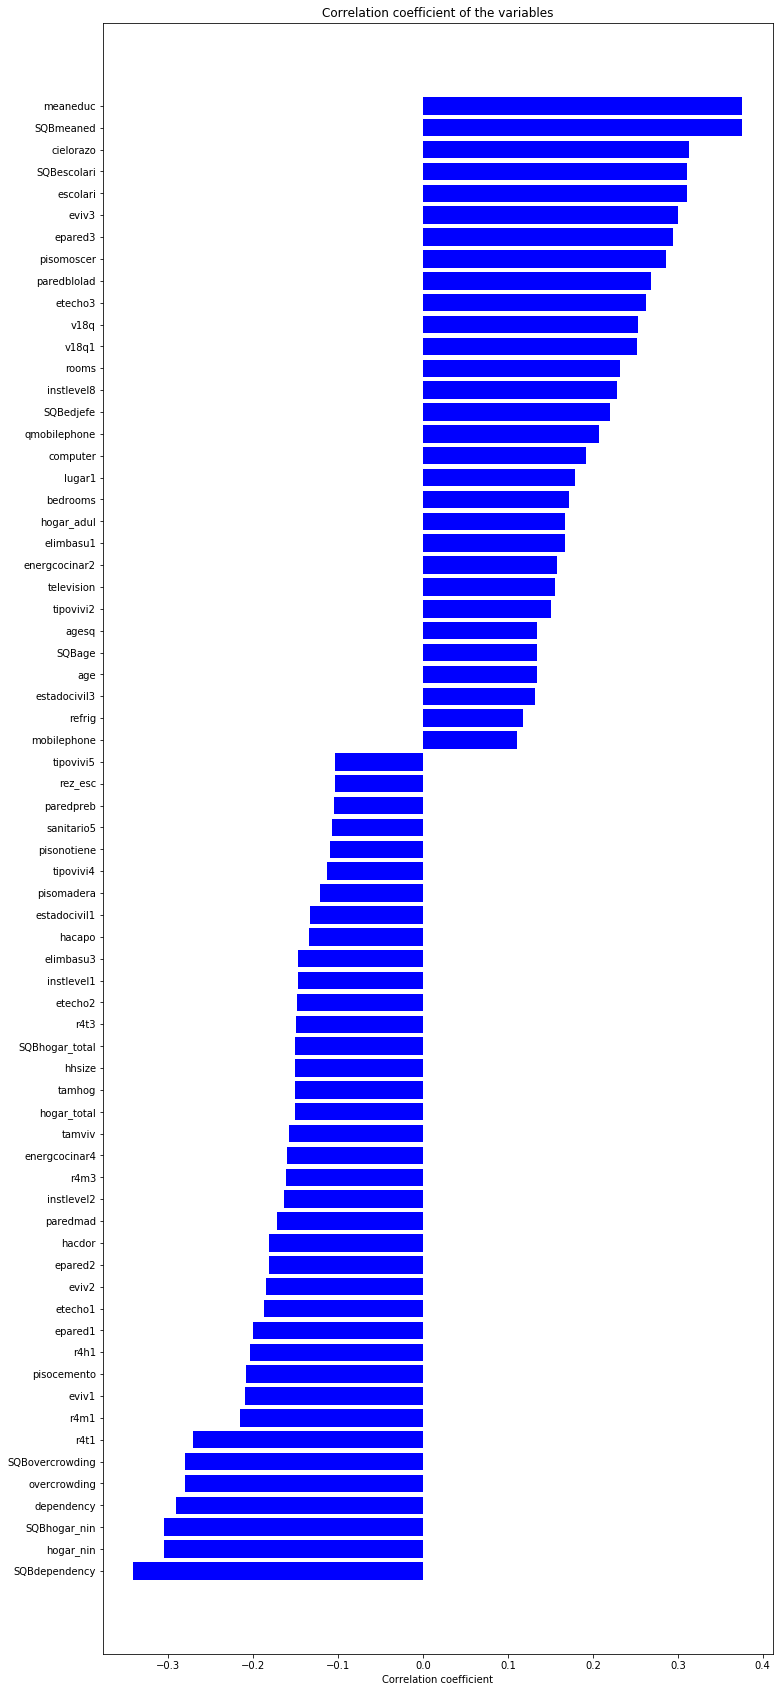

In [51]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in train_df.columns:
    if col not in ["Id", "Target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["Target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

I do not see any features that have any high degree of correlation with the target feature. As the next step we can check for correlation between the independendent features 

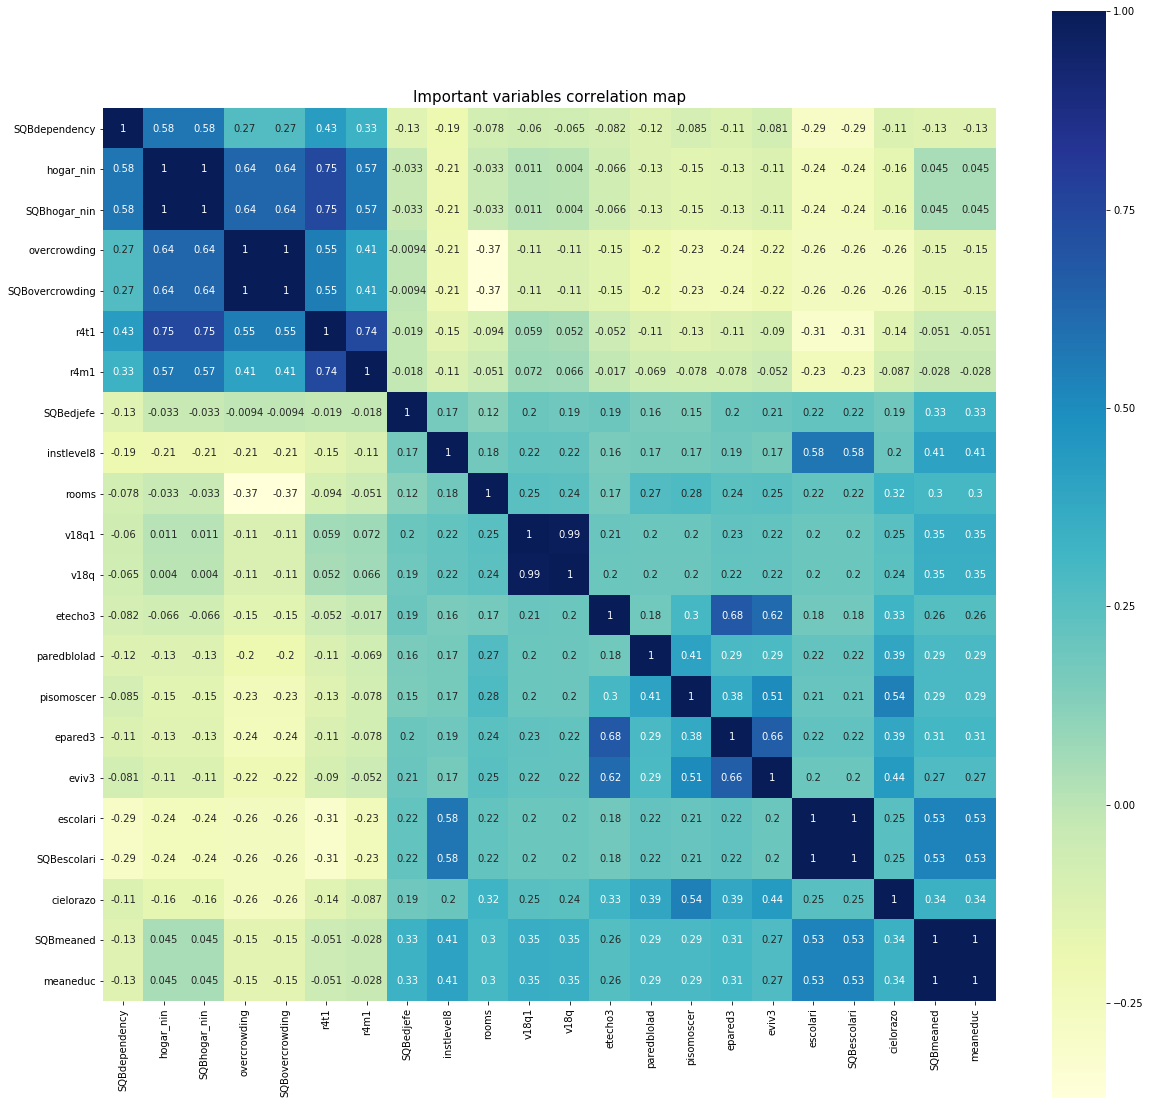

In [52]:
cols_to_use = corr_df[(corr_df['corr_values']>0.21) | (corr_df['corr_values']<-0.21)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

We saw that none of the features is strongly correlated with the target feature and hence I dont expect any particular feature will have high feature importance. Nevertheless lets check by fitting a classifier on the dataset and applying the feature imp function provided by that classifier

<h2> Feature Importance<h2>

In [53]:
train_X = imputed_df.drop(["Id", "Target"], axis=1)
train_y = imputed_df["Target"].values

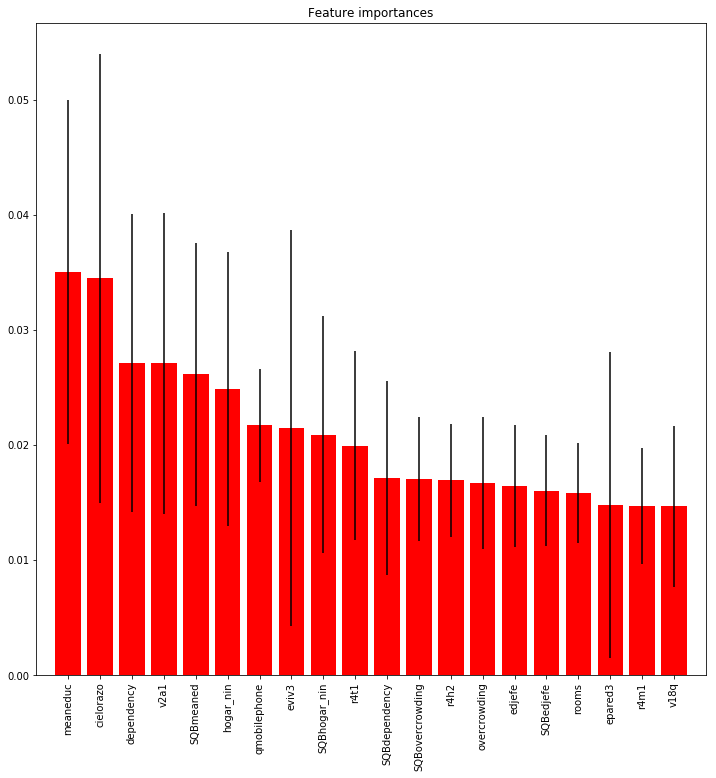

In [54]:
import sklearn
from sklearn import ensemble
model = ensemble.ExtraTreesClassifier(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
train_X=train_X.drop(['idhogar'],axis=1)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

As expected feature importance values that we see are low. Let us now fit a model on the preprocessed dataset to get a prediction and accuracy which we can use as benchmark and then apply the other algorithms and compare the accuracies

 <h2>First Benchmark Model- Logistic regression<h2>

In [55]:
from sklearn.linear_model import LogisticRegression

In [122]:
X=train_X

In [57]:
y=train_y

In [58]:
clf = LogisticRegression(random_state=0, solver='lbfgs',  multi_class='multinomial').fit(X, y)

In [59]:
test_df=pd.read_csv('test.csv')

In [60]:
test_df.shape

(23856, 142)

In [61]:
test_df_orig=test_df

<h2>Preprocess/Impute test data <h2>

In [62]:
test_df=test_df.replace('no','0')
test_df=test_df.replace('yes','1')

In [63]:
test_df.shape

(23856, 142)

In [64]:
test_df['rez_esc'].fillna(0, inplace=True)
test_df['meaneduc'].fillna(0, inplace=True)
test_df['SQBmeaned'].fillna(0, inplace=True)
test_df['v18q1'].fillna(0, inplace=True)
test_df['rez_esc'].fillna(0, inplace=True)

In [65]:
test_df.shape

(23856, 142)

In [66]:
test_df_reg=test_df

In [67]:
test_df_reg_train=test_df_reg[~test_df_reg['v2a1'].isnull()]

In [68]:
test_df_reg_train.shape

(6453, 142)

In [69]:
test_df_reg_test=test_df_reg[test_df_reg['v2a1'].isnull()]

In [70]:
test_df_reg_test.shape	

(17403, 142)

In [71]:
test_df_reg_train_Y=test_df_reg_train['v2a1']

In [72]:
test_df_reg_test_Y=test_df_reg_test['v2a1']

In [73]:
test_df_reg_train_X=test_df_reg_train.loc[:, test_df_reg_train.columns != 'v2a1']

In [74]:
test_df_reg_test_X=test_df_reg_test.loc[:, test_df_reg_test.columns != 'v2a1']

In [75]:
test_df_reg_train_X_id=test_df_reg_train_X

In [76]:
test_df_reg_train_X=test_df_reg_train_X.drop(['Id','idhogar'],axis=1)

In [77]:
test_df_reg_test_X_id=test_df_reg_test_X

In [78]:
test_df_reg_test_X=test_df_reg_test_X.drop(['Id','idhogar'],axis=1)

In [79]:
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)

In [80]:
regr.fit(test_df_reg_train_X,test_df_reg_train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
test_df_reg_test_Y=regr.predict(test_df_reg_test_X)

In [82]:
test_df_reg_test_Y=np.round(test_df_reg_test_Y)

In [83]:
test_df_reg_test_Y = pd.DataFrame(test_df_reg_test_Y, dtype='float')

In [84]:
test_df_reg_test_Y.shape

(17403, 1)

In [85]:
test_df_reg_test_X_id.loc[:,'v2a1']=test_df_reg_test_Y.values

In [86]:
test_df_reg_test_X_id.shape

(17403, 142)

In [87]:
test_df_reg_train_X_id.loc[:,'v2a1']=test_df_reg_train_Y.values

In [88]:
test_df_reg_train_X_id['v2a1']

4        175000.0
5        400000.0
6        400000.0
7        300000.0
8        300000.0
10        90000.0
11        90000.0
12        90000.0
13       200000.0
14       200000.0
15       200000.0
16       200000.0
17       200000.0
18       200000.0
19       240000.0
20       240000.0
21       240000.0
24       210000.0
25       210000.0
26       210000.0
27       210000.0
34       275000.0
35       275000.0
36       275000.0
37       275000.0
39       275000.0
40       275000.0
41       275000.0
42       275000.0
43       275000.0
           ...   
23725     65000.0
23726     65000.0
23727     65000.0
23728     65000.0
23744     70000.0
23745     70000.0
23746     70000.0
23747     70000.0
23748     70000.0
23751     55000.0
23752     55000.0
23753     55000.0
23754     55000.0
23755     55000.0
23756     55000.0
23765     40000.0
23766     40000.0
23767     40000.0
23796    200000.0
23797    200000.0
23798    200000.0
23799    200000.0
23800     30000.0
23801     30000.0
23802     

In [89]:
output_test_df = pd.concat([test_df_reg_train_X_id, test_df_reg_test_X_id], axis=0, ignore_index=True,sort='False')

In [90]:
output_test_df.shape

(23856, 142)

In [91]:
merge_test_df=output_test_df[['Id','v2a1']]

In [92]:
imputed_test_df=test_df.merge(merge_test_df,on='Id',how='outer')

In [93]:
imputed_test_df.shape

(23856, 143)

In [94]:
imputed_test_df=imputed_test_df.drop(['v2a1_x'],axis=1)

In [95]:
imputed_test_df=imputed_test_df.rename(index=str, columns={"v2a1_y": "v2a1"})

In [96]:
imputed_test_df=imputed_test_df.drop(['Id','idhogar'],axis=1)

In [97]:
imputed_test_df.shape

(23856, 140)

In [98]:
imputed_test_df= imputed_test_df.drop(['elimbasu5'],axis=1)

In [99]:
target_y=clf.predict(imputed_test_df)

In [100]:
target_y

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [101]:
type(test_df_orig['Id'])

pandas.core.series.Series

In [102]:
len(test_df_orig['Id'])

23856

In [103]:
submission_df=pd.concat([test_df_orig['Id'], pd.Series(target_y)], axis=1)

In [104]:
submission_df.shape

(23856, 2)

In [105]:
submission_df=submission_df.rename(index=int, columns={0: "Target"})

In [107]:
submission_df.to_csv('submission.csv', index=False)

Simple Logistic regression gave a score of 0.194 in Kaggle. Lets now Implement a Simple RF classifier

<h2>Basic RF Classifier <h2> 

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=0,n_jobs=-1)

In [110]:
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [111]:
target_y=rf_clf.predict(imputed_test_df)

In [112]:
submission_df=pd.concat([test_df_orig['Id'], pd.Series(target_y)], axis=1)
submission_df=submission_df.rename(index=int, columns={0: "Target"})
submission_df.to_csv('submission.csv', index=False)

Score with RF Classifier improved to 0.372! Jump from Rank 550 to 392! 

<h2>XGBoost<h2>

In [113]:
from xgboost import XGBClassifier

In [114]:
model = XGBClassifier()

In [123]:
X=X.replace('no',0)
X=X.replace('yes',1)

In [124]:
X['dependency']=X['dependency'].astype(str).astype(float,copy=True)

In [126]:
X['edjefe']=X['edjefe'].astype(str).astype(int,copy=True)

In [127]:
X['edjefa']=X['edjefa'].astype(str).astype(int,copy=True)

In [ ]:
type(X['dependency'])

In [ ]:
X.to_csv('debug.csv')

In [128]:
dtype_df = X.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int32,2
1,int64,128
2,float64,9


In [129]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [131]:
imputed_test_df['dependency']=imputed_test_df['dependency'].astype(str).astype(float,copy=True)
imputed_test_df['edjefe']=imputed_test_df['edjefe'].astype(str).astype(float,copy=True)
imputed_test_df['edjefa']=imputed_test_df['edjefa'].astype(str).astype(float,copy=True)

In [132]:
target_y=model.predict(imputed_test_df)

In [133]:
submission_df=pd.concat([test_df_orig['Id'], pd.Series(target_y)], axis=1)
submission_df=submission_df.rename(index=int, columns={0: "Target"})
submission_df.to_csv('submission.csv', index=False)